# ML analysis and DI estimation

In this notebook, the damage index is estimated using a machine learning algorithm and an adequately chosen feature set.

### Importing necessary libraries

In [1]:
import json
import os
from sklearn.model_selection import train_test_split
from ml_tools.analyzers import Reader, Writer
from ml_tools.plots import ParetoPlotter, RealPredictedPlotter
from ml_tools.predictor import Predictor
from ml_tools.helpers import create_simulation, get_processed_data_from_csv
from ml_tools.trainer import Trainer
from config import FeatureConfigReader, ModelsConfig, Config

### Define paths to JSON and CSV Files

To set up the models and each feature used in the investigation, JSON config files are used.

The main data file is [data_P3.csv](CSV_files/data_P3.csv).

- **"[comparison_V2.json](config/comparison_V2.json)":** Used for comparing ML algorithms with different hyperparameters.
- **"[features_V2.json](config/features_V2.json)":** Used to define model features.
- **"[models_V2_RF.json](config/models_V2_RF.json)":** Used to define different ML algorithm employed in this project, specifically "random forrest".
- **"[data_P3.csv](CSV_files/data_P3.csv)":** Contains damage index simulation results.




In [2]:
comparison_config_file_name = os.path.join("config", "comparison_V2.json")
features_config_file_name = os.path.join("config", "features_v2.json")
models_config_file_name = os.path.join("config", "models_V2_RF.json")
data_file_name = os.path.join("CSV_files", "data_P3.csv")
results_file_name = "results_comparison"
scaler_options = ["min-max scale"]
ALL_FEATURES_COUNT = 23

### Extract features and models from config files

In [3]:
models_config = ModelsConfig(models_config_file_name)
models = models_config.get_model_names()
print(models_config.config_data)  # Pentru a verifica datele încărcate
features_config = FeatureConfigReader(features_config_file_name)
print(features_config)  # Afișează lista de modele
best_features_by_set = features_config.get_all_features_dictionary()

{'models': {'random forrest': {'no_hyper_params': {}, 'with_hyper_params_optimisation': {}, 'pareto_color_no_hyper_params': 'purple', 'pareto_color_with_hyper_params': 'blue'}}}


### Initialize data storage dictionaries and lists

These data structures are used for visually representing results.

In [4]:
pareto_data_sets = { 'R2 vs. MAE': { 'R2' : [], 'MAE' : [] },
                        'MAE vs. FUR': { 'MAE' : [], 'FUR' : [] },
                        'R2 vs. FUR': { 'R2' : [], 'FUR' : [] }}

legend_elements = []
markers = []
colors = []
readers = []

### Creating a general configuration file for investigated simulation experiments

For each model-feature set pair, a configuration is developed.

In [5]:
def create_simulations_config_file(features_set):
    base_simulation = {
        "description": features_set,
        "features": [],
        "model": {
            "type": "",
            "hyper_parameters": {}
        }
    }

    all_simulations = {"simulations": {}}
    simulation_count = 1

    for model in models:
        options = ["no_hyper_params"] if "regression" in model else ["no_hyper_params"]

        for option in options:
            
            current_simulation  = create_simulation(base_simulation, features, model, option, models_config)
            
            # Add the current_simulation dictionary to the all_simulations dictionary
            all_simulations["simulations"][f"simulation {simulation_count} {features_set}"] = current_simulation
            
            simulation_count += 1

    with open(comparison_config_file_name, "w") as f:
        json.dump(all_simulations, f, indent=4)

### Utility function for bi-dimensional representation of results

Since results will be plotted considering several indicators, a processing function is used to return an uniform value considering the axis of the respective plot.

In [6]:
def get_value_for_pareto_plot(reader, indicator, data_type):
    for performance in reader.performances:
        if performance.indicator == indicator and performance.data_type == data_type:
            if indicator == "R2":
                return (1-performance.value)
            else:
                return performance.value
    return None

### Training and testing the model on the predefined feature sets

All simulation scenarios configured in the main file are executed.

In each scenario, a model is trained on a training data set and tested afterwards on a test data set.

For each scenario, performances are represented graphically.


---------------------------
Random forrest: MAE (test): 0.03 | MSE (test): 0.01 | R2 (test): 0.96 | MAE (train): 0.01 | MSE (train): 0.0 | R2 (train): 0.99 | 


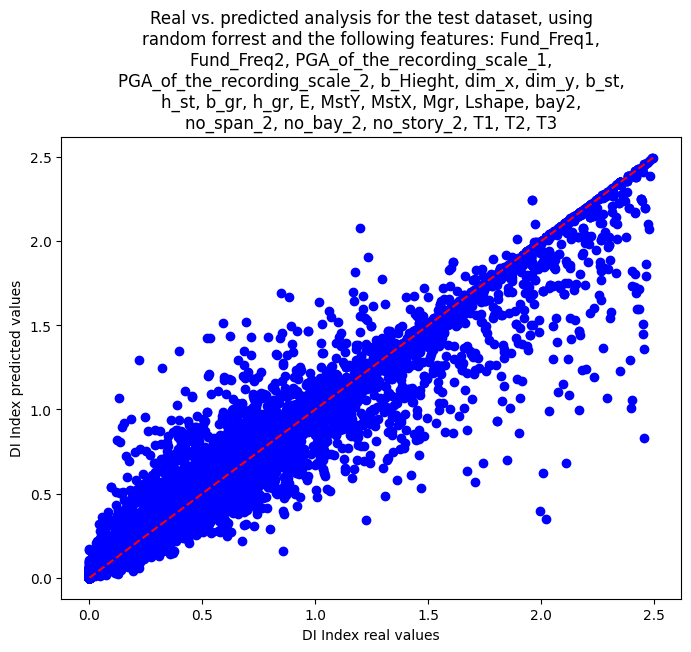

In [21]:
for features_set, features in best_features_by_set.items():

    create_simulations_config_file(features_set)

    # Machine learning analysis
    processed_data = get_processed_data_from_csv(data_file_name)

    y = processed_data['DI_cladire'] 

    config = Config(comparison_config_file_name)
    
    simulations = config.get_simulations()
    
    for simulation in simulations:

        selected_features = config.get_features(simulation)
        x = processed_data[selected_features]
        model_type = config.get_model_type(simulation)
        hyper_params = config.get_hyper_parameters(simulation)
        
        if hyper_params:
            option = "with hyper-params"
        else:
            option = ""
        
        if "min-max scale" in scaler_options:
            trainer = Trainer(x, y, model_type, hyper_params, use_min_max_scale=True)
        else:
            trainer = Trainer(x, y, model_type, hyper_params)
        trainer.set_train_test_data(test_size=0.2)
        trainer.train_model()
        
        predictor = Predictor(trainer)
        predictor.set_prediction_on_test()
        predictor.set_prediction_on_train()

        reader = Reader(simulation, trainer, predictor)
        reader.set_performances_on_test_data()
        reader.set_performances_on_train_data()

        print("---------------------------")
        reader.print_performances()
        readers.append(reader)
        
        writer = Writer(config, simulation,reader.performances, results_file_name)
        writer.append_to_csv()
        
        # Collecting performance data for plotting
        pareto_data_sets["R2 vs. MAE"]["R2"].append(get_value_for_pareto_plot(reader, "R2", "test"))
        pareto_data_sets["R2 vs. MAE"]["MAE"].append(get_value_for_pareto_plot(reader, "MAE", "test"))
        pareto_data_sets["R2 vs. FUR"]["R2"].append(get_value_for_pareto_plot(reader, "R2", "test"))
        pareto_data_sets["R2 vs. FUR"]["FUR"].append(len(features)/ALL_FEATURES_COUNT)
        pareto_data_sets["MAE vs. FUR"]["MAE"].append(get_value_for_pareto_plot(reader, "MAE", "test"))
        pareto_data_sets["MAE vs. FUR"]["FUR"].append(len(features)/ALL_FEATURES_COUNT)
        
        legend_elements.append(f"{model_type} {option}, {features_set}")
        
        marker = features_config.get_pareto_marker(features_set)
        markers.append(marker)  
        
        color = models_config.get_pareto_color(model_type, option)
        colors.append(color) 
        
        plotter = RealPredictedPlotter(config, "figs", False, simulation, features_set, features, trainer, predictor)
        plotter.generate_plot()